In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import konlpy
from konlpy.tag import Mecab, Okt, Hannanum, Kkma, Komoran
import math
import os
import re
import tensorflow as tf
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

DATA_DIR = 'data'
SEED = 123

In [3]:
train = pd.read_csv('unsmile_train_v1.0.tsv', '\t')
val = pd.read_csv('unsmile_valid_v1.0.tsv', '\t')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15005 entries, 0 to 15004
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   문장      15005 non-null  object
 1   여성/가족   15005 non-null  int64 
 2   남성      15005 non-null  int64 
 3   성소수자    15005 non-null  int64 
 4   인종/국적   15005 non-null  int64 
 5   연령      15005 non-null  int64 
 6   지역      15005 non-null  int64 
 7   종교      15005 non-null  int64 
 8   기타 혐오   15005 non-null  int64 
 9   악플/욕설   15005 non-null  int64 
 10  clean   15005 non-null  int64 
 11  개인지칭    15005 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 1.4+ MB


In [6]:
from pykospacing import Spacing
import hanja

spacing = Spacing()

def preprocess(sentence):
    sentence = hanja.translate(sentence, 'combination-text')
    sentence =re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9\\s]', '', sentence)
    return spacing(sentence)

In [239]:
train_preprocess = train['문장'].apply(preprocess)

TypeError: list indices must be integers or slices, not str

In [12]:
val_preprocess = val['문장'].apply(preprocess)

In [17]:
train_preprocess[:5]

0                           일 안 하는 시간은 쉬고 싶어서 그런 게 아닐까
1    아동 성범죄와 페도 버는 기록 바 끊어져 영원히 고통 받는 다 무슬림 50퍼 근친이...
2    루나 솔로 앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o do in 진짜 ...
3    홍팍에도 어버이연합 인가 보내요 뭐 이런 뎃글 있는데 이 거 어버이연합 측에 신고하...
4    아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다 여자들은 더 심하게 그런 ...
Name: 문장, dtype: object

In [19]:
val_preprocess[:5]

0    ㅇㄱㄹㅇ 진짜 죽어도 상관없다는 마인드로 싸웠더니 지금 서 열 상타 취노 식칼들 고...
1                           여자들은 취미가 애낳는 건 가 취미를 좀 가져라
2                            개슬람녀 다 필요 없고 니 엄마만 있으면 된다
3    조팔ㅋㅋ 남한 길거리 돌아다니면 한국 남자 때문에 눈재기하는데 그걸 내 폰에 굳이 ...
4                              바지 내리다 한남들 와 꾸 보고 올려 뿟노
Name: 문장, dtype: object

In [32]:
# Mecab, Okt, Hannanum, Kkma, Komoran
def make_tokenizer(sentence, token):
    if token == 'mecab':
        return Mecab()
    elif token == 'okt':
        return Okt()
    elif token == 'kkma':
        return Kkma()
    elif token == 'hannanum':
        return Hannanum()
    elif token == 'komoran':
        return Komoran()
def make_token(sentence, tokenizer, token):
    rs = []
    stop_words = ['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한']
    for st in sentence:
        if token in ['mecab', 'okt', 'kkma', 'komoran', 'hannaum']:
            tokens = tokenizer.morphs(st)
            tokens = [t for t in tokens if t not in stop_words]
        token_append = ' '.join(tokens)
        rs.append(token_append)
    return rs

In [33]:
tokenizer = make_tokenizer(train_preprocess, 'mecab')
train = make_token(train_preprocess, tokenizer, 'mecab')
val =  make_token(val_preprocess, tokenizer, 'mecab')

In [34]:
train[:5]

['일 안 시간 쉬 고 싶 어서 그런 게 아닐까',
 '아동 성범죄 와 페도 버 기록 바 끊 어 져 영원히 고통 받 다 무슬림 50 퍼 근친 다 10 16 까지 IQ 떨어지 고 출산 위험 400 다',
 '루나 솔로 앨범 나왔 을 때 부터 머 모 기운 었 음 ㅇㅇ Keep o do in 진짜 띵 곡 임 꼭 어 셈',
 '홍 팍 에 도 어버이 연합 인가 보내 요 뭐 이런 뎃글 는데 거 어버이 연합 측 에 신고 면 그쪽 에서 고소 가능 냐',
 '놔 왜 여기 댓 다 여자 김치 녀 라고 먼저 불렸 다 여자 더 심하 게 그런 다 이렇게 2 개 로 싸우 냐 내 볼 땐 둘 다 나쁜 말 그 이상 도 하도 아닌데']

In [35]:
sentence_length = pd.Series(train).str.split().apply(lambda x: len(x)).max()
sentence_length

82

<AxesSubplot:ylabel='Count'>

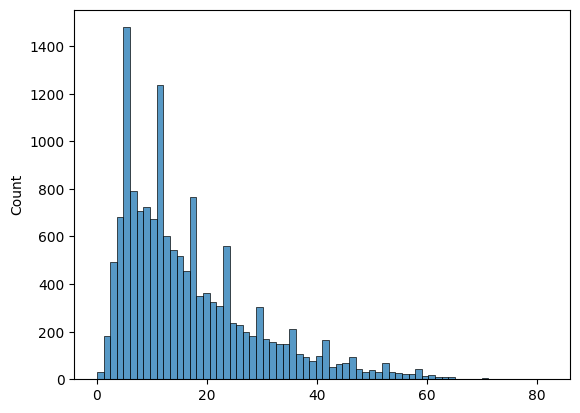

In [36]:
sns.histplot(pd.Series(train).str.split().apply(lambda x: len(x)))

In [162]:
train_df = pd.read_csv('unsmile_train_v1.0.tsv', '\t')
val_df = pd.read_csv('unsmile_valid_v1.0.tsv', '\t')

In [163]:
train_df[:5]

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0


In [164]:
def add(a, b, c, d, e, f, g, h, i, j, k):
    return a*(10**-5) + b*(10**-4) + c*(10**-3) + d*(10**-2) + e*(10**-1) + f*(1) + g*(10**2) + h*(10**3) + i*(10**4) + j*(500) + k*(1500)

In [165]:
train_df['label'] = train_df.apply(lambda row : add(row['여성/가족'],row['남성'], row['성소수자'], row['인종/국적'], row['연령'], row['지역'], row['종교'], row['기타 혐오'], row['악플/욕설'], row['clean'], row['개인지칭']), axis = 1)
val_df['label'] = val_df.apply(lambda row : add(row['여성/가족'],row['남성'], row['성소수자'], row['인종/국적'], row['연령'], row['지역'], row['종교'], row['기타 혐오'], row['악플/욕설'], row['clean'], row['개인지칭']), axis = 1)

In [166]:
def label(x):
    if x == 500:
        return 10
    elif x == 1500:
        return 11
    elif x == 10**-5:
        return 0
    elif x == 10**-4:
        return 1
    elif x == 10**-3:
        return 2
    elif x == 10**-2:
        return 3
    elif x == 10**-1:
        return 4
    elif x == 1:
        return 5
    elif x == 10:
        return 6 
    elif x == 10**2:
        return 7
    elif x == 10**3:
        return 8
    elif x == 10**4:
        return 9
    else:
        return -1

In [167]:
train_df['label'] = train_df['label'].apply(label)
val_df['label'] = val_df['label'].apply(label)

In [168]:
train_df['label'].value_counts()

 10    3739
 9     3089
-1     1282
 0     1251
 3     1190
 1     1110
 2      936
 7      845
 5      823
 4      430
 8      310
Name: label, dtype: int64

In [169]:
val_df['label'].value_counts()

 10    935
 9     772
 0     313
-1     306
 3     298
 1     277
 2     234
 7     211
 5     206
 4     108
 8      77
Name: label, dtype: int64

In [170]:
data = {'sentence': val, 'label':val_df['label']}
val_df = pd.DataFrame(data)

In [171]:
data = {'sentence': train, 'label':train_df['label']}
train_df = pd.DataFrame(data)

In [173]:
train_df = train_df.loc[train_df['label'] >= 0]
val_df = val_df.loc[val_df['label'] >= 0]

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer(min_df=0.00, analyzer='word', ngram_range=(1, 5), max_features=7500).fit(train)
train_vectors = tfidfv.transform(train_df['sentence'])
test_vectors = tfidfv.transform(val_df['sentence'])
train_vectors.shape, test_vectors.shape

((13723, 7500), (3431, 7500))

In [176]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_vectors,
                                                    train_df['label'],
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [177]:
from lightgbm import LGBMClassifier

tfidf_model = LGBMClassifier(num_leaves=15, 
                             n_estimators=1000, 
                             learning_rate=0.05, 
                             colsample_bytree=0.8, 
                             subsample=0.8, 
                             random_state=SEED, 
                             n_jobs=-1,
                            )

In [178]:
tfidf_model.fit(x_train, y_train, eval_metric="logloss")
pred = tfidf_model.predict(x_valid)

In [179]:
(pred == y_valid).mean()

0.5438979963570127

In [194]:
train_df

,sentence,label
0,일 안 시간 쉬 고 싶 어서 그런 게 아닐까,10
1,아동 성범죄 와 페도 버 기록 바 끊 어 져 영원히 고통 받 다 무슬림 50 퍼 근...,7
2,루나 솔로 앨범 나왔 을 때 부터 머 모 기운 었 음 ㅇㅇ Keep o do in ...,10
3,홍 팍 에 도 어버이 연합 인가 보내 요 뭐 이런 뎃글 는데 거 어버이 연합 측 에...,10
4,놔 왜 여기 댓 다 여자 김치 녀 라고 먼저 불렸 다 여자 더 심하 게 그런 다 이...,0
...,...,...
14999,성소 수자 이빈 띤 좆 같 고 뱡신 같 말 누가 만드 거 냐,2
15000,께 롱 께 롱 께 롱,10
15001,갱 상도 아니 라 홍어 지 개 좃 같 홍어 년,5
15003,링크 도 안 박 고 서 글 쓰 자고 선동 네,9


In [203]:
val_df

,sentence,label
0,ㅇㄱㄹㅇ 진짜 죽 어도 상관없 다는 마인드 로 싸웠 더니 지금 서 열 상 타 취 노...,1
1,여자 취미 애 낳 건 취미 를 좀 가져라,0
3,조 팔 ㅋㅋ 남 길거리 돌아다니 면 한국 남자 때문 에 눈 재기 는데 그걸 내 폰 ...,1
4,바지 내리 다 한남 와 꾸 고 올려 뿟 노,1
5,저 새끼 슈스케 나 온 새끼 잖 ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ...,9
...,...,...
3732,저게 시대 적 언어 면 남충 도 시대 적 언어 아니 노 ㅋㅋ,1
3733,다른 보다 눈 어떻게 저렇게 생기 노탄 식,9
3734,막노동 을 해도 한국 에 살 고 말 지 미쳤 다고 남미 를 냐 차라리 자살 을 겠 다,3
3735,사형 을 구형 였으나 여성 인 점 을 감안 해 25 년 선고 내 뭐 잘못 본 건가 ...,0


In [195]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_df['sentence'],
                                                    train_df['label'], 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [246]:
vocab_size = 7500
embedding_dim = 256

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['sentence'])

train_sequences = tokenizer.texts_to_sequences(x_train)
validation_sequences = tokenizer.texts_to_sequences(x_valid)
test_sequences = tokenizer.texts_to_sequences(val_df['sentence'])

train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=sentence_length)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=sentence_length)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=sentence_length)

In [254]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['sentence'])
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=sentence_length)

In [255]:
lstm_model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sentence_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(11, activation='softmax')
        ])

In [256]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 82, 256)           1920000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 82, 128)          164352    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dense_16 (Dense)            (None, 32)               

In [257]:
checkpoint_path = 'tmp/tmp_model.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                monitor='val_loss',
                                                verbose=1)

In [258]:
optimizer = tf.keras.optimizers.Adam(0.00001)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [259]:
lstm_model.fit(train_padded, y_train, 
               validation_data=(validation_padded, y_valid),
               callbacks=[checkpoint],
               epochs=10)

Epoch 1/10
342/344 [============================>.] - ETA: 0s - loss: 1.8487 - accuracy: 0.3299
Epoch 00001: val_loss improved from inf to 1.68172, saving model to tmp/tmp_model.ckpt
344/344 [==============================] - 10s 20ms/step - loss: 1.8485 - accuracy: 0.3298 - val_loss: 1.6817 - val_accuracy: 0.3552
Epoch 2/10
341/344 [============================>.] - ETA: 0s - loss: 1.2864 - accuracy: 0.5356
Epoch 00002: val_loss improved from 1.68172 to 1.22941, saving model to tmp/tmp_model.ckpt
344/344 [==============================] - 6s 17ms/step - loss: 1.2869 - accuracy: 0.5358 - val_loss: 1.2294 - val_accuracy: 0.5719
Epoch 3/10
341/344 [============================>.] - ETA: 0s - loss: 0.8740 - accuracy: 0.7177
Epoch 00003: val_loss improved from 1.22941 to 1.15005, saving model to tmp/tmp_model.ckpt
344/344 [==============================] - 6s 17ms/step - loss: 0.8732 - accuracy: 0.7180 - val_loss: 1.1501 - val_accuracy: 0.6448
Epoch 4/10
343/344 [==========================

In [269]:
predictions = lstm_model.predict(test_padded)

In [272]:
pred = predictions.argmax(axis = 1)
test

array([10, 10,  1,  1,  9,  1,  9, 10,  9,  5, 10,  9,  2, 10,  1,  3, 10,
        1,  9,  1,  9,  9, 10,  0,  3,  9,  2,  0,  9, 10,  9, 10,  5,  0,
        9,  9, 10,  9,  9,  8,  9,  0, 10,  7,  0,  9, 10,  1, 10,  3])

In [274]:
val_df['pred'] = pred

In [474]:
val_df[:20]

,sentence,label,pred
0,ㅇㄱㄹㅇ 진짜 죽 어도 상관없 다는 마인드 로 싸웠 더니 지금 서 열 상 타 취 노...,1,10
1,여자 취미 애 낳 건 취미 를 좀 가져라,0,10
3,조 팔 ㅋㅋ 남 길거리 돌아다니 면 한국 남자 때문 에 눈 재기 는데 그걸 내 폰 ...,1,1
4,바지 내리 다 한남 와 꾸 고 올려 뿟 노,1,1
5,저 새끼 슈스케 나 온 새끼 잖 ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ...,9,9
7,또 남자 네 역시 남충 절레절레,1,1
9,잘생긴 형 같 음 절대로 여자 로 안 보임 ㅇㅇ,0,9
10,여성 혐오 도 아니 고 상식 비상식 문제 다 저게 한국 사회 약 거 지 독 될 거 ...,9,10
11,오히려 태평양 패권 을 두 고 싸운 일본 넘 두렵 게 느껴 지 게 정상 인데 ㅋㅋㅋ...,3,9
12,딱 전라도 마인드 임 통수 쩌 위선자,5,5


In [296]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [294]:
train_df

,Unnamed: 0,sentence,label
0,0,일 안 시간 쉬 고 싶 어서 그런 게 아닐까,10
1,1,아동 성범죄 와 페도 버 기록 바 끊 어 져 영원히 고통 받 다 무슬림 50 퍼 근...,7
2,2,루나 솔로 앨범 나왔 을 때 부터 머 모 기운 었 음 ㅇㅇ Keep o do in ...,10
3,3,홍 팍 에 도 어버이 연합 인가 보내 요 뭐 이런 뎃글 는데 거 어버이 연합 측 에...,10
4,4,놔 왜 여기 댓 다 여자 김치 녀 라고 먼저 불렸 다 여자 더 심하 게 그런 다 이...,0
...,...,...,...
13718,14999,성소 수자 이빈 띤 좆 같 고 뱡신 같 말 누가 만드 거 냐,2
13719,15000,께 롱 께 롱 께 롱,10
13720,15001,갱 상도 아니 라 홍어 지 개 좃 같 홍어 년,5
13721,15003,링크 도 안 박 고 서 글 쓰 자고 선동 네,9


In [299]:
test_df = test_df.drop('pred', axis = 1)

In [309]:
df = pd.concat([train_df, test_df])

In [471]:
df.head()

,Unnamed: 0,sentence,label,words
0,0,일 안 시간 쉬 고 싶 어서 그런 게 아닐까,10,"[일, 안, 시간, 쉬, 고, 싶, 어서, 그런, 게, 아닐까]"
1,1,아동 성범죄 와 페도 버 기록 바 끊 어 져 영원히 고통 받 다 무슬림 50 퍼 근...,7,"[아동, 성범죄, 와, 페도, 버, 기록, 바, 끊, 어, 져, 영원히, 고통, 받..."
2,2,루나 솔로 앨범 나왔 을 때 부터 머 모 기운 었 음 ㅇㅇ Keep o do in ...,10,"[루나, 솔로, 앨범, 나왔, 을, 때, 부터, 머, 모, 기운, 었, 음, ㅇㅇ,..."
3,3,홍 팍 에 도 어버이 연합 인가 보내 요 뭐 이런 뎃글 는데 거 어버이 연합 측 에...,10,"[홍, 팍, 에, 도, 어버이, 연합, 인가, 보내, 요, 뭐, 이런, 뎃글, 는데..."
4,4,놔 왜 여기 댓 다 여자 김치 녀 라고 먼저 불렸 다 여자 더 심하 게 그런 다 이...,0,"[놔, 왜, 여기, 댓, 다, 여자, 김치, 녀, 라고, 먼저, 불렸, 다, 여자,..."


In [337]:
df['words'] = df['sentence'].str.split()

In [472]:
df.head()

,Unnamed: 0,sentence,label,words
0,0,일 안 시간 쉬 고 싶 어서 그런 게 아닐까,10,"[일, 안, 시간, 쉬, 고, 싶, 어서, 그런, 게, 아닐까]"
1,1,아동 성범죄 와 페도 버 기록 바 끊 어 져 영원히 고통 받 다 무슬림 50 퍼 근...,7,"[아동, 성범죄, 와, 페도, 버, 기록, 바, 끊, 어, 져, 영원히, 고통, 받..."
2,2,루나 솔로 앨범 나왔 을 때 부터 머 모 기운 었 음 ㅇㅇ Keep o do in ...,10,"[루나, 솔로, 앨범, 나왔, 을, 때, 부터, 머, 모, 기운, 었, 음, ㅇㅇ,..."
3,3,홍 팍 에 도 어버이 연합 인가 보내 요 뭐 이런 뎃글 는데 거 어버이 연합 측 에...,10,"[홍, 팍, 에, 도, 어버이, 연합, 인가, 보내, 요, 뭐, 이런, 뎃글, 는데..."
4,4,놔 왜 여기 댓 다 여자 김치 녀 라고 먼저 불렸 다 여자 더 심하 게 그런 다 이...,0,"[놔, 왜, 여기, 댓, 다, 여자, 김치, 녀, 라고, 먼저, 불렸, 다, 여자,..."


In [343]:
from collections import Counter
from wordcloud import WordCloud

In [468]:
def label(a):    
    label = df.loc[df['label'] == a]
    rt = []
    for i in range(len(label_0)):
        rt.extend(label['words'])
    dct = {}
    for i in range(len(rt)):
        for items in (rt[i]):
            dct[items] = dct.get(items, 0) + 1
    wordCloud = WordCloud(font_path = 'malgun.ttf', width = 2000, height = 1000).generate_from_frequencies(dct)
    plt.figure()
    plt.imshow(wordCloud)
    plt.axis('off')

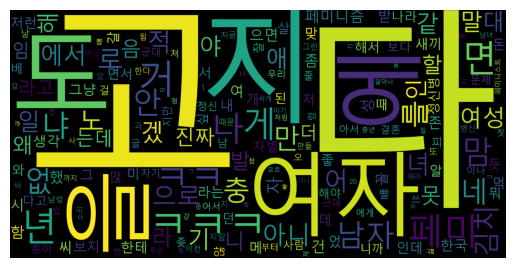

In [470]:
label(0) # 여성/가족

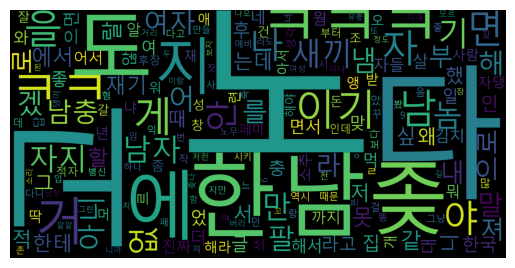

In [469]:
label(1) # 남성 

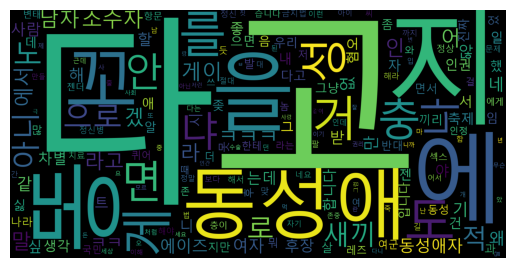

In [475]:
label(2) # 성소수자  

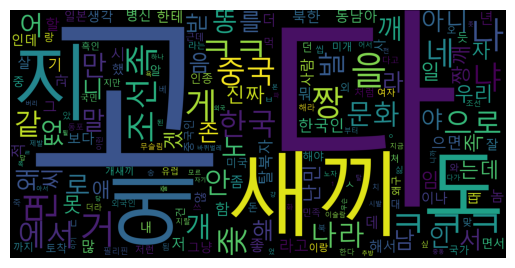

In [476]:
label(3) # 인종/국적  

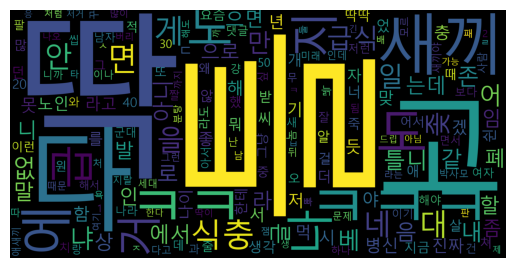

In [477]:
label(4) # 연령 

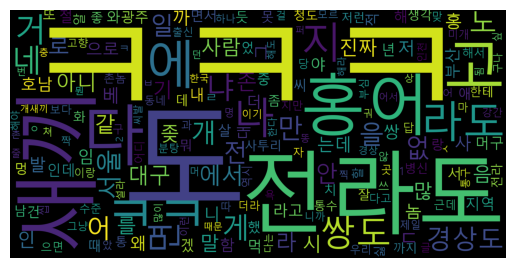

In [478]:
label(5) # 지역  

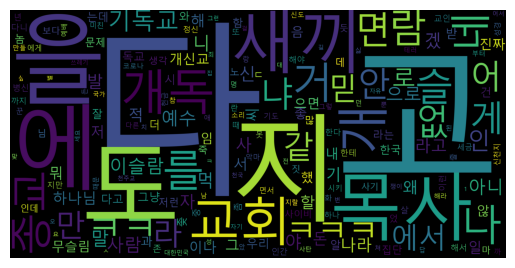

In [481]:
label(7) # 기타  

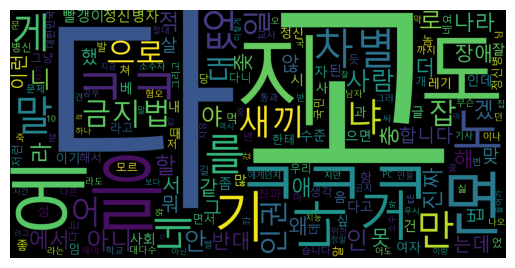

In [482]:
label(8) # 혐오  

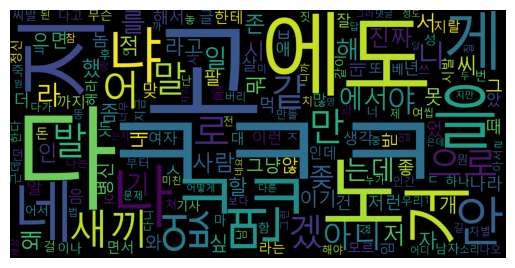

In [483]:
label(9) # 악플/욕설